In [ ]:
# follow site
# https://medium.com/alex-attia-blog/the-simpsons-character-recognition-using-keras-d8e1796eae36
# https://www.kaggle.com/code/hartlehar/simpsons-character-identifier

+ **이미지 분석 방향**
  + [x] Image Classification
  + [ ] Image Segmentation
  + [ ] Object detection
  + [ ] Visual Embedding

<center><img src="https://149695847.v2.pressablecdn.com/wp-content/uploads/2017/09/localizationVsDetection.png" position="relative" width="600"></center>

---

+ **Index**
  + [ ] data read(read image)
  + [ ] dataset split
  + [ ] image size normailzation
  + [ ] modeling
  + [ ] train/save
  + [ ] evaluation
  + [ ] predict/visualization


In [1]:
import tensorflow as tf
import cv2 as cv, numpy as np
import os
import matplotlib.pyplot as plt
import glob
import pathlib

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from keras.optimizers import SGD, Adam

In [2]:
# data read
char_path = r'C:/Users/khpark/archive/simpsons_dataset'

char_names = []
for char in os.listdir(char_path):
    char_names.append(char)
char_names.sort()
map_characters  = {i : char_names[i] for i in range(len(char_names))}

data = tf.keras.utils.image_dataset_from_directory(char_path)


# data split
train_size = int(len(data)*.8)
val_size   = int(len(data)*.2)

train_ds = data.take(train_size)
val_ds = data.skip(train_size).take(val_size)


# image size normalization

normalization = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x,y: (normalization(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

Found 20933 files belonging to 42 classes.


In [58]:
# TF page version

# data read
data_dir = pathlib.Path(char_path)
# image_count = len(list(data_dir.glob('*/*.jpg')))
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=123, image_size=(256, 256), batch_size=batch_size)
val_ds   = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation",seed=123,image_size=(256, 256), batch_size=batch_size)

# image size normalization

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# class_names = train_ds.class_names

Found 20933 files belonging to 42 classes.
Using 16747 files for training.
Found 20933 files belonging to 42 classes.
Using 4186 files for validation.


In [ ]:
# map_characters 내용의 저장
import json

with open('./data.json','w') as f:
  json.dump(map_characters, f, ensure_ascii=False, indent=4)

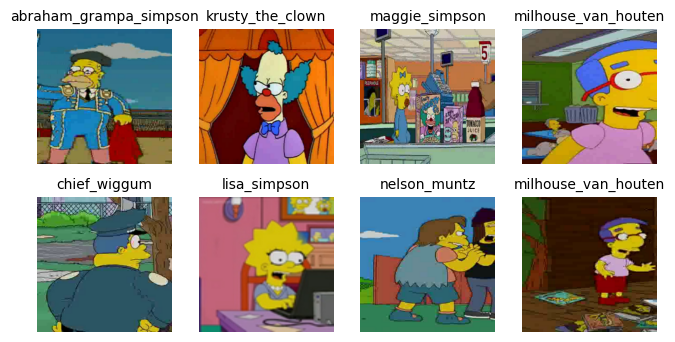

In [3]:
# data check
plt.figure(figsize=(8, 4))
for images, labels in data.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(char_names[labels[i]], fontsize = 10)
    plt.axis("off")

42


In [37]:
num_classes = len(char_names)

In [38]:
X_test, y_test = load_test_set(char_path)

Test set (0,) (0, 42)


In [75]:
def CNN_model(output_size):
    input_layer = tf.keras.Input(shape=(256,256, 3), name='InputLayer')

    conv1 = tf.keras.layers.Conv2D(filters = 32, kernel_size=[3,3], padding = 'SAME', activation=tf.nn.relu )(input_layer)
    conv1 = tf.keras.layers.Conv2D(filters = 32, kernel_size=[3,3], activation=tf.nn.relu )(conv1)
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding = 'SAME')(conv1)
    drop1 = tf.keras.layers.Dropout(0.2)(pool1)

    conv2 = tf.keras.layers.Conv2D(filters = 64, kernel_size=[3,3], padding = 'SAME', activation=tf.nn.relu )(drop1)
    conv2 = tf.keras.layers.Conv2D(filters = 64, kernel_size=[3,3], activation=tf.nn.relu )(conv2)
    pool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding = 'SAME')(conv2)
    drop2 = tf.keras.layers.Dropout(0.2)(pool2)

    conv3 = tf.keras.layers.Conv2D(filters = 256, kernel_size=[3,3], padding = 'SAME', activation=tf.nn.relu )(drop2)
    conv3 = tf.keras.layers.Conv2D(filters = 256, kernel_size=[3,3], activation=tf.nn.relu )(conv3)
    pool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding = 'SAME')(conv3)
    drop3 = tf.keras.layers.Dropout(0.2)(pool3)

    flat4 = tf.keras.layers.Flatten()(drop3)
    dense4 = tf.keras.layers.Dense(units = 1024, activation = 'relu' )(flat4)
    drop4 = tf.keras.layers.Dropout(0.2)(dense4)
    logits = tf.keras.layers.Dense(units = output_size , activation = 'softmax' )(dense4)

    model = Model(inputs= input_layer, outputs = logits )

    return model


In [4]:
def CNN_model(output_size):
    input_layer = tf.keras.Input(shape=(256,256, 3), name='InputLayer')
    input_rescaling= tf.keras.layers.Rescaling(1./255)(input_layer)

    conv1 = tf.keras.layers.Conv2D(filters = 32, kernel_size=3, padding = 'SAME', activation=tf.nn.relu )(input_rescaling)
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding = 'SAME')(conv1)
    drop1 = tf.keras.layers.Dropout(0.2)(pool1)

    conv2 = tf.keras.layers.Conv2D(filters = 32, kernel_size=3, padding = 'SAME', activation=tf.nn.relu )(drop1)
    pool2 = tf.keras.layers.MaxPool2D()(conv2)
    drop2 = tf.keras.layers.Dropout(0.2)(pool2)

    conv3 = tf.keras.layers.Conv2D(filters = 32, kernel_size=3, padding = 'SAME', activation=tf.nn.relu )(drop2)
    pool3 = tf.keras.layers.MaxPool2D()(conv3)
    drop3 = tf.keras.layers.Dropout(0.1)(pool3)

    flat4 = tf.keras.layers.Flatten()(drop3)
    dense4 = tf.keras.layers.Dense(units = 128, activation = 'relu' )(flat4)
    logits = tf.keras.layers.Dense(units = output_size , activation = 'softmax' )(dense4)

    model = Model(inputs= input_layer, outputs = logits )

    return model

In [78]:
# model = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(len(char_names))
# ])

In [5]:
model = CNN_model( len(char_names) )
opt = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt, metrics=['accuracy']) 

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                             

In [8]:
# train
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20


524/524 [==============================] - 1330s 3s/step - loss: 2.4536 - accuracy: 0.3323 - val_loss: 2.1714 - val_accuracy: 0.4283
Epoch 2/20
524/524 [==============================] - 1354s 3s/step - loss: 1.7159 - accuracy: 0.5339 - val_loss: 1.6995 - val_accuracy: 0.5676
Epoch 3/20
524/524 [==============================] - 1302s 2s/step - loss: 1.2667 - accuracy: 0.6517 - val_loss: 1.5052 - val_accuracy: 0.6041
Epoch 4/20
524/524 [==============================] - 1323s 3s/step - loss: 0.8959 - accuracy: 0.7445 - val_loss: 1.3386 - val_accuracy: 0.6502
Epoch 5/20
524/524 [==============================] - 1282s 2s/step - loss: 0.5781 - accuracy: 0.8303 - val_loss: 1.3886 - val_accuracy: 0.6504
Epoch 6/20
524/524 [==============================] - 1269s 2s/step - loss: 0.4083 - accuracy: 0.8741 - val_loss: 1.4485 - val_accuracy: 0.6759
Epoch 7/20
524/524 [==============================] - 1243s 2s/step - loss: 0.3133 - accuracy: 0.9083 - val_loss: 1.5052 - val_accuracy: 0.6576
Epo

In [9]:
# save model
model.save("simpson_model.h5")

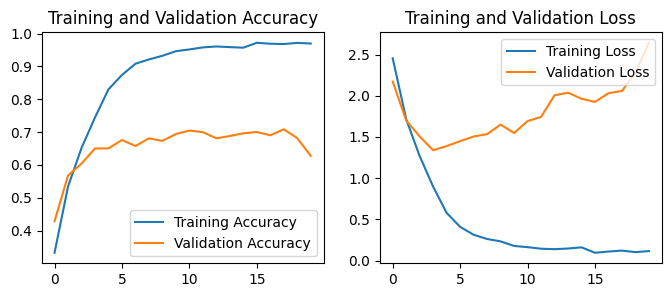

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [1]:
import tensorflow as tf
import cv2, numpy as np
import os
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

In [10]:
# load model
model = load_model('simpson_model.h5')

with open("data.json", "r") as st_json:
    map_characters = json.load(st_json)

In [4]:
image_path = r'./test_image'
image_file = os.listdir(image_path)

In [22]:
from mpl_toolkits.axes_grid1 import AxesGrid
import glob


i= 2
image = cv2.imread(  image_path+ '/' + image_file[i] )
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pic = cv2.resize(image, (256, 256)).astype('float32') / 255.
a = model.predict(pic.reshape(1, 256, 256,3))[0]
img = cv2.resize(img, (352, 352))


plt.figure(figsize=(8, 4))
for images, labels in data.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(char_names[labels[i]], fontsize = 10)
    plt.axis("off")

1/1 [==============================] - 0s 67ms/step


NameError: name 'data' is not defined

<Figure size 800x400 with 0 Axes>

In [23]:
sorted(enumerate(a), key=lambda x:x[1], reverse=True)

[(15, 0.39356166),
 (17, 0.19646004),
 (41, 0.10126985),
 (32, 0.056525424),
 (11, 0.042570915),
 (28, 0.024063103),
 (33, 0.018485425),
 (24, 0.014532946),
 (21, 0.01329389),
 (20, 0.012130297),
 (27, 0.010764411),
 (34, 0.010684457),
 (23, 0.010218642),
 (1, 0.009618435),
 (35, 0.009312766),
 (37, 0.008748132),
 (19, 0.007338393),
 (13, 0.006512053),
 (3, 0.0058683422),
 (6, 0.005797154),
 (40, 0.00433428),
 (4, 0.0037031402),
 (10, 0.0033835352),
 (36, 0.003040504),
 (25, 0.0028534767),
 (30, 0.0025911843),
 (22, 0.002433309),
 (39, 0.0022028636),
 (7, 0.0020399832),
 (14, 0.0019016375),
 (12, 0.0016893807),
 (38, 0.0016670616),
 (26, 0.0016184571),
 (18, 0.0014300458),
 (5, 0.0014107532),
 (0, 0.0014080341),
 (31, 0.0013986564),
 (8, 0.0013588317),
 (16, 0.0008153375),
 (9, 0.00047246428),
 (2, 0.00040305223),
 (29, 8.759294e-05)]

In [29]:
import urllib
pic_size = 256

def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def plot_and_predict(url, all_perc=False):
    image = url_to_image(url)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    pic = cv2.resize(image, (pic_size,pic_size))
    a = model.predict(pic.reshape(1, pic_size, pic_size,3))[0]
    if all_perc:
        print('\n'.join(['{} : {}%'.format(map_characters[i], round(k*100)) for i,k in sorted(enumerate(a), key=lambda x:x[1], reverse=True)]))
    else:
        return map_characters[np.argmax(a)].replace('_',' ').title()

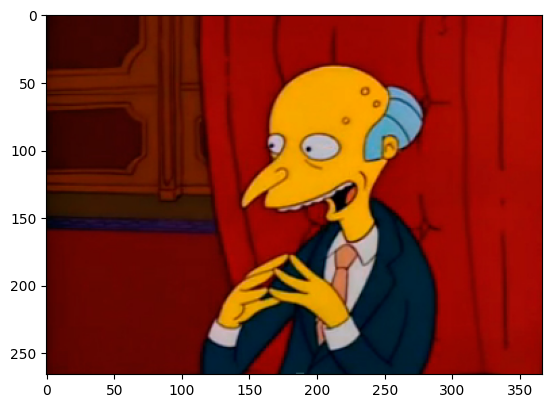

1/1 [==============================] - 0s 339ms/step


KeyError: 32

In [30]:
url = "https://vignette3.wikia.nocookie.net/simpsons/images/2/25/Adult_burns.jpg/revision/latest?cb=20111012170021"
plot_and_predict(url)

In [31]:
url = "https://vignette3.wikia.nocookie.net/simpsons/images/2/25/Adult_burns.jpg/revision/latest?cb=20111012170021"
image = url_to_image(url)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pic = cv2.resize(image, (pic_size,pic_size))
model.predict(pic.reshape(1, pic_size, pic_size, 3))[0]

1/1 [==============================] - 0s 88ms/step


array([ -2.2579446 ,  -3.8058324 ,   2.2283833 , -20.528994  ,
        -4.558924  ,  -9.386998  ,   4.4912577 ,  -5.665197  ,
       -25.319338  , -13.032991  , -13.204689  ,  -7.9470615 ,
       -11.802665  , -12.734407  ,   3.881499  ,  10.18308   ,
        -0.93604803,   9.943252  ,   0.04125799, -14.579056  ,
        -1.8143433 , -11.413136  ,   1.5138639 , -17.829689  ,
         0.43230143,  -6.215172  ,  -9.009007  ,   8.644521  ,
        -2.6559517 , -15.799013  , -17.742641  , -10.037847  ,
        11.571765  , -10.782399  ,  -5.7719665 , -23.677069  ,
        -9.324683  ,  -3.3249042 , -14.085719  , -26.98768   ,
       -13.660357  ,   3.7399979 ], dtype=float32)

1/1 [==============================] - 1s 509ms/step


ValueError: 'a' cannot be empty unless no samples are taken

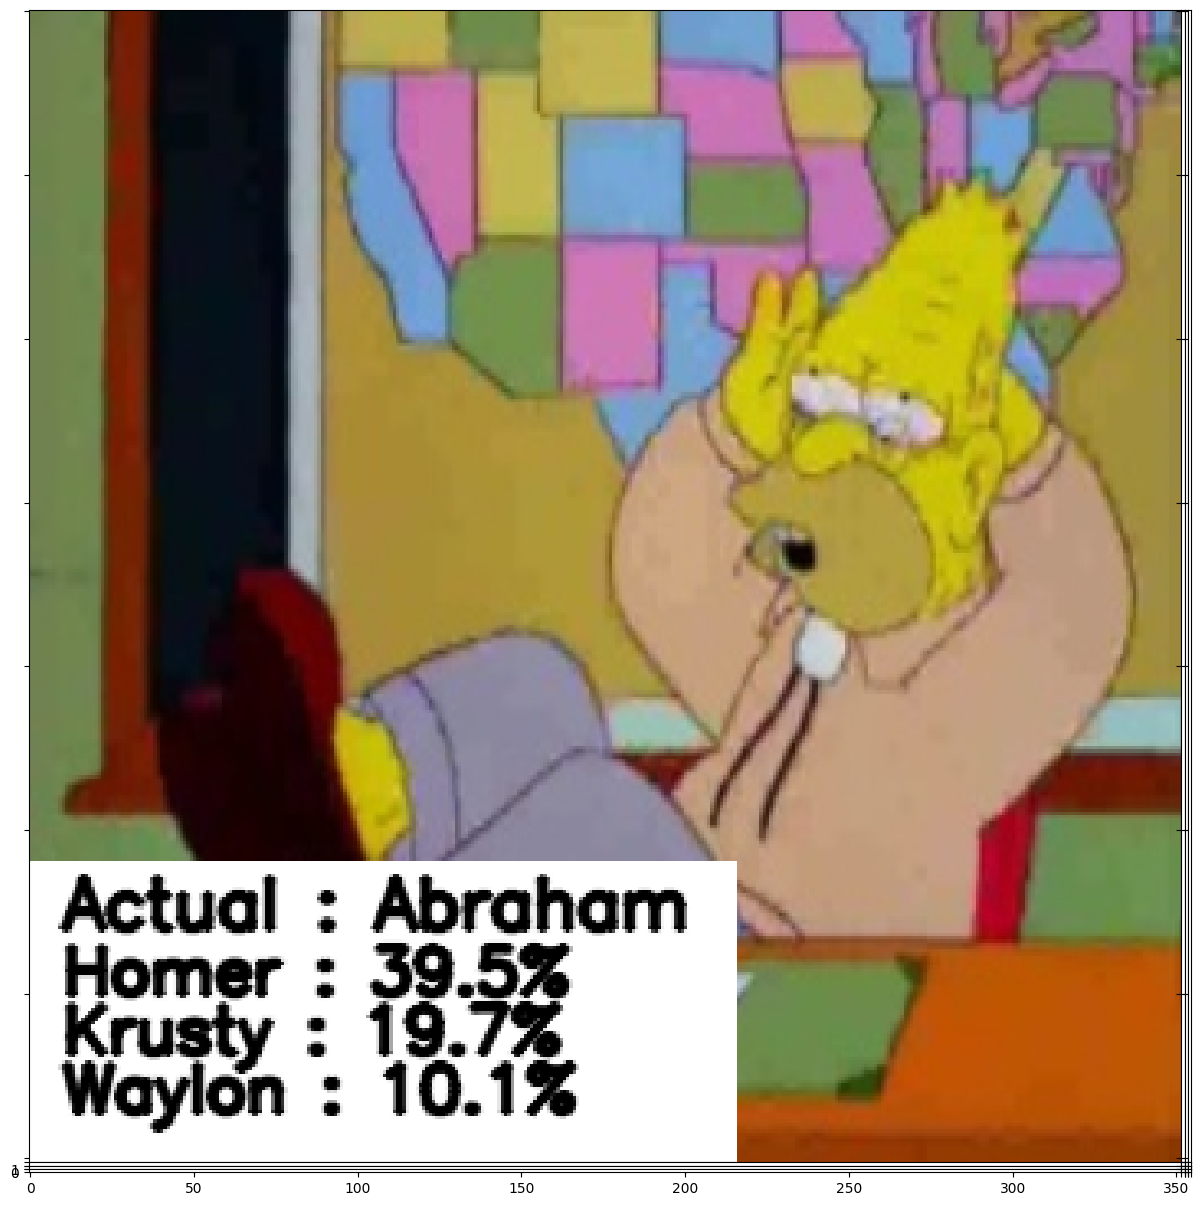

In [6]:
from mpl_toolkits.axes_grid1 import AxesGrid
import glob

# data read
char_path = r'C:/Users/khpark/archive/simpsons_dataset'

char_names = []
for char in os.listdir(char_path):
    char_names.append(char)
char_names.sort()
map_characters  = {i : char_names[i] for i in range(len(char_names))}


F = plt.figure(1, (15,20))
grid = AxesGrid(F, 111, nrows_ncols=(4, 4), axes_pad=0, label_mode="1")

for i in range(16):
    char = map_characters[i]
    image = cv2.imread(np.random.choice([k for k in glob.glob('C:/Users/khpark/archive/kaggle_simpson_testset/*.*') if char in k]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pic = cv2.resize(image, (256, 256)).astype('float32') / 255.
    a = model.predict(pic.reshape(1, 256, 256,3))[0]
    actual = char.split('_')[0].title()
    text = sorted(['{:s} : {:.1f}%'.format(map_characters[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
       key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    img = cv2.resize(img, (352, 352))
    cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0,0,0),2,cv2.LINE_AA)
    for k, t in enumerate(text):
        cv2.putText(img, t,(10, 300+k*18), font, 0.65,(0,0,0),2,cv2.LINE_AA)
    grid[i].imshow(img)